In [1]:
import pandas as pd
import numpy as np
import altair as alt
import config
import fidap
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# set up fidap connection
fidap = fidap.fidap_client(api_key = config.api_key)

### America's Housing Crisis  
  
Everyone knows that the US is in the midst of a housing crisis where affordable housing is an oxymoronic phrase in some of the more desirable cities. An [NYT article](https://www.nytimes.com/2021/08/10/opinion/housing-crisis-eviction.html) from yesterday (August 10, 2021) shows why.   
  
[Research](https://www.apartmentlist.com/research/national-rent-data) has also pointed towards rising rental prices across the country.    
  
We can make use of data from Redfin, Zillow, and Apartment List to identify which parts of the US have seen a revival in the housing market.   

In [6]:
# getting state and county names and shapefile
continental_county_boundaries = fidap.sql("""
SELECT c.lsad_name, s.state, CONCAT(c.lsad_name, ", ", s.state) AS full_county_name, 
c.geo_id, c.county_geom 
FROM bigquery-public-data.geo_us_boundaries.counties AS c
INNER JOIN bigquery-public-data.geo_us_boundaries.states AS s
ON s.state_fips_code = c.state_fips_code
WHERE c.state_fips_code NOT IN ('02', '15', '66', '72', '69', '78', '60');
""")

# continental_county_boundaries.county_geom = continental_county_boundaries.county_geom.apply(wkt.loads)
# continental_county_boundaries_gdf = gpd.GeoDataFrame(continental_county_boundaries, geometry = 'county_geom', crs = 'epsg:4326')

In [3]:
## we do not really have to run the following

# querying for redfin sales data since 2020
redfin_sales = fidap.sql("""
SELECT region_name, period_begin, period_end, LEFT(period_end, 4) AS period_year, SUBSTR(period_end, 6, 2) AS period_month,  
total_homes_sold, total_active_listings, total_new_listings, median_active_list_ppsf, median_new_listing_ppsf, inventory, age_of_inventory, median_days_on_market, median_sale_ppsf, median_pending_sqft, percent_active_listings_with_price_drops, price_drop_percent_of_old_list_price, percent_homes_sold_above_list, percent_homes_sold_with_price_drops
FROM fidap-301014.redfin.weekly_housing_market
WHERE CAST(period_begin AS DATE) > "2019-12-31"
AND duration = "1 weeks"
AND region_type = "county"
""")

# converting period into datetime64
redfin_sales.period_begin = pd.to_datetime(redfin_sales.period_begin)
redfin_sales.period_end = pd.to_datetime(redfin_sales.period_end)

# obtain month - we can do it in sql as well 
#redfin_sales['period_month'] = pd.DatetimeIndex(redfin_sales['period_end']).month
#redfin_sales['period_year'] = pd.DatetimeIndex(redfin_sales['period_end']).year

In [19]:
redfin_sales.head()

,region_name,period_begin,period_end,total_homes_sold,total_active_listings,total_new_listings,median_active_list_ppsf,median_new_listing_ppsf,inventory,age_of_inventory,median_days_on_market,median_sale_ppsf,median_pending_sqft,percent_active_listings_with_price_drops,price_drop_percent_of_old_list_price,percent_homes_sold_above_list,percent_homes_sold_with_price_drops,period_month,period_year
0,"Calhoun County, AL",2020-01-06,2020-01-12,11.0,436.0,22.0,73.781388,84.894664,417.0,96.0,62.0,50.898204,1680.5,0.032110,0.071160,0.181818,0.181818,1,2020
1,"Etowah County, AL",2020-01-06,2020-01-12,13.0,383.0,21.0,75.478931,63.753582,367.0,107.0,76.0,66.666667,1650.0,0.041775,0.051590,0.076923,0.307692,1,2020
2,"Limestone County, AL",2020-01-06,2020-01-12,31.0,449.0,40.0,112.673213,113.056253,408.0,75.0,62.0,99.939394,1954.0,0.033408,0.033255,0.290323,0.161290,1,2020
3,"Talladega County, AL",2020-01-06,2020-01-12,14.0,287.0,16.0,87.889688,80.791223,274.0,100.0,100.5,89.505612,1759.0,0.031359,0.032676,0.214286,0.428571,1,2020
4,"Pima County, AZ",2020-01-06,2020-01-12,242.0,3894.0,416.0,147.095179,149.460422,3591.0,59.0,51.0,143.128821,1569.0,0.047252,0.033224,0.157025,0.268595,1,2020


#### Transaction Volumes  
  
The easiest indicator is to look at transaction volumes.  

In [6]:
# weekly homes sold
#weekly_homes_sold = redfin_sales.groupby(['period_end']).agg(
#    homes_sold = ('total_homes_sold', sum)
#)
#weekly_homes_sold = weekly_homes_sold.reset_index()

weekly_homes_sold = fidap.sql("""
SELECT period_end, SUM(CAST(total_homes_sold AS FLOAT64)) AS total_homes_sold
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND CAST(period_begin AS DATE) > "2019-12-31"
GROUP BY period_end
""")

weekly_homes_sold.period_end = pd.to_datetime(weekly_homes_sold.period_end)

# plotting it
alt.Chart(weekly_homes_sold).mark_line(point = True).encode(
    x = alt.X('period_end', title = "Date"),
    y = alt.Y('total_homes_sold', title = "No. of Homes Sold")
)

alt.Chart(...)

In [7]:
#monthly_homes_sold = redfin_sales.groupby(['period_month', 'period_year']).agg(
#    total_homes_sold = ('total_homes_sold', sum)
#)

#monthly_homes_sold = monthly_homes_sold.reset_index()

monthly_homes_sold = fidap.sql("""
SELECT LEFT(period_end, 4) AS period_year, SUBSTR(period_end, 6, 2) AS period_month, SUM(CAST(total_homes_sold AS FLOAT64)) AS total_homes_sold
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND CAST(period_begin AS DATE) > "2019-12-31"
GROUP BY LEFT(period_end, 4), SUBSTR(period_end, 6, 2)
""")

# plotting it
alt.Chart(monthly_homes_sold).mark_line(point = True).encode(
    x = alt.X('period_month', title = "Month of Year"),
    y = alt.Y('total_homes_sold', title = "No. of Homes Sold"),
    color = alt.Color('period_year:N', title = "Year")
)

alt.Chart(...)

What we can conclude is that across the country, transaction volumes have risen, and are higher than 2020.  
  
Which are some of the counties that have seen the most amount of action? 

In [8]:
#redfin_sales_sorted = redfin_sales.copy()
# redfin_sales_sorted['weekly_rank'] = redfin_sales_sorted.groupby('period_end')['total_homes_sold'].rank('dense', ascending = False)

# ranking query
redfin_sales_sorted = fidap.sql("""
SELECT period_end, CAST(total_homes_sold AS FLOAT64) AS total_homes_sold, region_name,
ROW_NUMBER() OVER(PARTITION BY period_end ORDER BY CAST(total_homes_sold AS FLOAT64) DESC) AS weekly_rank
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND CAST(period_begin AS DATE) > "2019-12-31"
""")

redfin_sales_sorted.period_end = pd.to_datetime(redfin_sales_sorted.period_end)

# top 3 counties by transaction volume
redfin_sales_sorted_top = redfin_sales_sorted[(redfin_sales_sorted['weekly_rank']<4)]


# plotting
alt.Chart(redfin_sales_sorted_top).mark_line().encode(
    x = alt.X('period_end', title = "Date"),
    y = alt.Y('total_homes_sold', title = "No. of Homes Sold", impute = alt.ImputeParams(value = None)),
    color = alt.Color('region_name', title = "County")
)

alt.Chart(...)

The counties with the highest transaction volumes are the big urban counties corresponding to Chicago, Houston, Los Angeles, and Phoenix. This did not change despite the pandemic. Cities remain desirable for buyers.  
  
At the same time, we also want to identify counties which saw the biggest jump in sales expressed in percentage. We can compare July 2020 with July 2021 since housing sales generally peak in the summer months.By the way, it is way easier in SQL than in Python with CTEs.   

In [19]:
# calculate the differences 
biggest_jumps = fidap.sql("""
WITH july_2020 AS (
SELECT SUM(CAST(total_homes_sold AS FLOAT64)) AS ths_jul20, region_name,
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND period_end LIKE '2020-07%'
GROUP BY region_name
),

july_2021 AS (
SELECT SUM(CAST(total_homes_sold AS FLOAT64)) AS ths_jul21, region_name,
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND period_end LIKE '2021-07%'
GROUP BY region_name
)

SELECT ju.region_name, ths_jul20, ths_jul21, ROUND(100*(ths_jul21-ths_jul20)/ths_jul20,2) AS homes_sold_delta_pct
FROM july_2021 AS ju 
INNER JOIN july_2020 AS ja
ON ju.region_name = ja.region_name
WHERE ths_jul20 > 10
""")

# reshaping
biggest_jumps = biggest_jumps.rename(columns = {
    'ths_jul20':'July 2020',
    'ths_jul21':'July 2021'
})

biggest_jumps = biggest_jumps.sort_values('homes_sold_delta_pct', ascending = False)
biggest_jumps = biggest_jumps.reset_index(drop = True)
biggest_jumps_top10 = biggest_jumps.loc[1:10,:]

biggest_jumps_long = pd.melt(biggest_jumps_top10, id_vars = ['region_name', 'homes_sold_delta_pct'], value_vars = ['July 2020', 'July 2021'])

# plotting

alt.Chart(biggest_jumps_long).mark_bar().encode(
    x = alt.X('variable', axis = alt.Axis(labels = False), title = None),
    y = alt.Y('value', title = "No. of Homes Sold"),
    color = alt.Color('variable', title = "Month"),
    column = alt.Column('region_name', title = "", header = alt.Header(labelAngle = 15, labelPadding = -30, labelOrient = 'top'))
)

alt.Chart(...)

In [5]:
ytd_transaction_vols = fidap.sql("""
WITH ths_2020 AS (
SELECT SUM(CAST(total_homes_sold AS FLOAT64)) AS ths_20, region_name
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND period_end LIKE '2020%'
GROUP BY region_name 
),

ths_2021 AS (
SELECT SUM(CAST(total_homes_sold AS FLOAT64)) AS ths_21, region_name,
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND period_end LIKE '2021%'
GROUP BY region_name
),

county_geom AS (
SELECT CONCAT(c.lsad_name, ", ", s.state) AS full_county_name, c.geo_id, c.county_geom 
FROM bigquery-public-data.geo_us_boundaries.counties AS c
INNER JOIN bigquery-public-data.geo_us_boundaries.states AS s
ON s.state_fips_code = c.state_fips_code
)

SELECT ju.region_name AS county, cg.geo_id AS geoid,  ths_20, ths_21, (100*(ths_21/ths_20)) AS homes_sold_pct,
ROW_NUMBER() OVER (ORDER BY ths_20 DESC) AS jan20_rank,
ROW_NUMBER() OVER (ORDER BY ths_21 DESC) AS jul21_rank,
ROW_NUMBER() OVER (ORDER BY ths_20 DESC) - ROW_NUMBER() OVER (ORDER BY ths_21 DESC) AS rank_change,
cg.county_geom AS geom
FROM ths_2021 AS ju 
INNER JOIN ths_2020 AS ja
ON ju.region_name = ja.region_name
INNER JOIN county_geom AS cg
ON ju.region_name = cg.full_county_name
WHERE ths_20 > 10 
""")

In [20]:
alt.Chart(ytd_transaction_vols).mark_bar().encode(
    x = alt.X('homes_sold_bin:Q',title = "Homes Sold in 2021 as % of 2020"),
    y = 'count()'
).transform_bin('homes_sold_bin', 'homes_sold_pct', bin = alt.Bin(step = 25))

alt.Chart(...)

What we can see is that generally, as of July 25 2021, transaction volumes for the year 2021 across most counties are up to 75% of transaction volumes for the entire year of 2020. This is generally little higher than expected. At the same time, we see that there is an extremely severe right skew which suggests that demand has spiked in certain counties.  

In [21]:
ytd_transaction_vols = ytd_transaction_vols.sort_values('rank_change', ascending = False)
ytd_transaction_vols.head(n = 10)

,region_name,ths_20,ths_21,homes_sold_pct,jan20_rank,jul21_rank,rank_change
318,"Hampden County, MA",46,1732.0,3765.217391,1281,319,962
141,"Marion County, FL",140,4698.0,3355.714286,1078,142,936
475,"Houston County, GA",18,812.0,4511.111111,1372,476,896
440,"Catawba County, NC",37,984.0,2659.459459,1307,441,866
593,"Hampshire County, MA",16,521.0,3256.250000,1383,594,789
606,"Coryell County, TX",24,489.0,2037.500000,1343,607,736
677,"Caldwell County, NC",21,378.0,1800.000000,1356,678,678
585,"Bradley County, TN",55,538.0,978.181818,1249,586,663
590,"Bibb County, GA",55,527.0,958.181818,1248,591,657
790,"McMinn County, TN",14,262.0,1871.428571,1397,791,606


Each county is first ranked by transaction volume in each year. And then, counties are ranked in descending order by the number of places it has moved up. We see that the counties which have seen the biggest increments in transaction volumes are largely in the South. 

In [22]:
ytd_transaction_vols = ytd_transaction_vols.sort_values('homes_sold_pct', ascending = False)

top_transaction_counties = ytd_transaction_vols[(ytd_transaction_vols['homes_sold_pct']>=100)]
top_transaction_counties.head(n=10)

,region_name,ths_20,ths_21,homes_sold_pct,jan20_rank,jul21_rank,rank_change
475,"Houston County, GA",18,812.0,4511.111111,1372,476,896
318,"Hampden County, MA",46,1732.0,3765.217391,1281,319,962
141,"Marion County, FL",140,4698.0,3355.714286,1078,142,936
593,"Hampshire County, MA",16,521.0,3256.250000,1383,594,789
440,"Catawba County, NC",37,984.0,2659.459459,1307,441,866
606,"Coryell County, TX",24,489.0,2037.500000,1343,607,736
790,"McMinn County, TN",14,262.0,1871.428571,1397,791,606
677,"Caldwell County, NC",21,378.0,1800.000000,1356,678,678
914,"DeKalb County, TN",12,182.0,1516.666667,1407,915,492
741,"Muskingum County, OH",25,299.0,1196.000000,1339,742,597


If we rank counties by increments in transaction volumes in terms of percentage change, again we see that Southern counties take the top spots.

In [53]:
state_col = top_transaction_counties['region_name'].str.split(", ", n = 1, expand = True)
top_transaction_counties.loc['state'] = state_col[1]
top_transaction_counties_states = top_transaction_counties.groupby('state').agg('count')
top_transaction_counties_states = top_transaction_counties_states.loc[:, "region_name"].reset_index().sort_values('region_name', ascending = False)
top_transaction_counties_states.head()

,state,region_name
3,GA,26
18,TX,10
17,TN,7
16,OK,7
2,FL,5


Really, if we look at counties in the United States that have already surpassed 2020's transaction volumes by end-July 2021, they are most commonly found in Southern states like GA, TX, TN, OK, and FL.

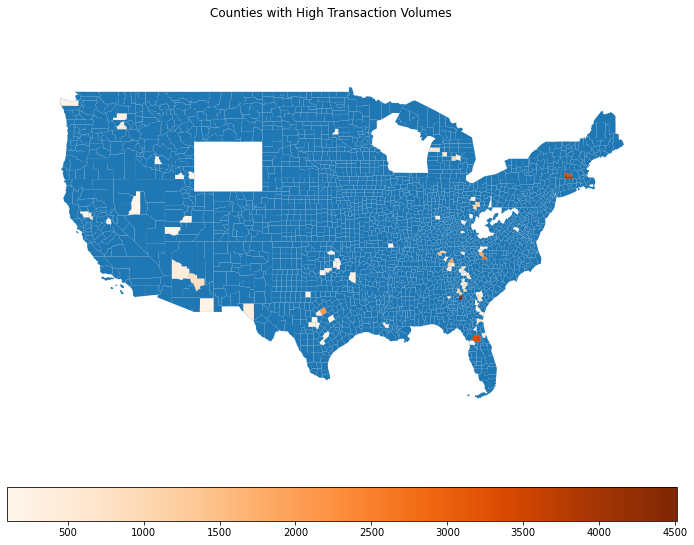

In [36]:
ytd_transaction_vols['geometry'] = gpd.GeoSeries.from_wkt(ytd_transaction_vols['geom'])
ytd_transaction_vols_gdf = gpd.GeoDataFrame(ytd_transaction_vols, 
                                            geometry = 'geometry', crs = 'epsg:4326')

# only continental US
ytd_transaction_vols_gdf_filtered = ytd_transaction_vols_gdf[(~ytd_transaction_vols_gdf['county'].str.contains('AK')) & (~ytd_transaction_vols_gdf['county'].str.contains('HI')) & (ytd_transaction_vols_gdf['homes_sold_pct']>100)]

fig, ax  = plt.subplots(figsize = (12,9))
continental_county_boundaries_gdf.plot(ax = ax, color = '#f0f0f0', )
ytd_transaction_vols_gdf_filtered.plot(ax = ax, column = 'homes_sold_pct', 
                                       cmap = 'Oranges', legend = True,
                                       legend_kwds = {'orientation':'horizontal'})
fig.suptitle("Counties with High Transaction Volumes")
ax.set_axis_off()
plt.show()

#### Transaction Prices

We can view changes in property prices across the entire US first. 

In [56]:
weekly_price_psf = fidap.sql("""
SELECT period_end, APPROX_QUANTILES(CAST(median_sale_ppsf AS FLOAT64), 100)[OFFSET(50)] AS Median, APPROX_QUANTILES(CAST(median_sale_ppsf AS FLOAT64),100)[OFFSET(75)] AS ThirdQuartile, APPROX_QUANTILES(CAST(median_sale_ppsf AS FLOAT64),100)[OFFSET(25)] AS FirstQuartile
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND CAST(period_begin AS DATE) > '2020-01-01'
GROUP BY period_end 
""")

weekly_price_psf = weekly_price_psf.reset_index()

weekly_price_psf.period_end = pd.to_datetime(weekly_price_psf.period_end)
weekly_price_psf = pd.melt(weekly_price_psf, id_vars = 'period_end', 
                           value_vars = ['Median', 'FirstQuartile', 'ThirdQuartile'])

alt.Chart(weekly_price_psf).mark_line(point = True).encode(
    x = alt.X('period_end', title = "Date"),
    y = alt.Y('value', title = 'Sale Price ($/psf)'),
    color = 'variable'
)

alt.Chart(...)

What we can see is that prices have risen across the board. The rate of sales price increase per square foot is generally the same at different price levels. However, prices in the higher range seem to have increased at a faster rate. I suppose we can look at states where prices have risen the most.  
  
Due to data querying and downloading restrictions, we have to smoothen out the data a litle by increasing the duration to 12 weeks and only looking at tranactions starting March 2020 when Covid-19 was just making its presence felt in the US.   

In [26]:
state_weekly_price_psf = fidap.sql("""
SELECT RIGHT(region_name, 2) AS state, period_end, APPROX_QUANTILES(CAST(median_sale_ppsf AS FLOAT64), 100)[OFFSET(50)] AS Median, APPROX_QUANTILES(CAST(median_sale_ppsf AS FLOAT64),100)[OFFSET(75)] AS ThirdQuartile, APPROX_QUANTILES(CAST(median_sale_ppsf AS FLOAT64),100)[OFFSET(25)] AS FirstQuartile
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '12 weeks'
AND region_type = 'county'
AND region_name NOT LIKE 'All Redfin Metros'
AND CAST(period_begin AS DATE) > '2020-03-01'
GROUP BY period_end, RIGHT(region_name, 2)
""")

state_weekly_price_psf = state_weekly_price_psf.reset_index()

state_weekly_price_psf.period_end = pd.to_datetime(state_weekly_price_psf.period_end)
state_weekly_price_psf = pd.melt(state_weekly_price_psf, id_vars = ['period_end', 'state'], 
                                 value_vars = ['Median', 'FirstQuartile', 'ThirdQuartile'])

# plotting
alt.data_transformers.disable_max_rows()
alt.Chart(state_weekly_price_psf).mark_line().encode(
    x = alt.X('period_end', title = "Date"),
    y = alt.Y('value', title = 'Sale Price ($/psf)'),
    color = 'variable',
    facet = alt.Facet('state:O', columns = 5)
).properties(width = 100, height = 100)

alt.Chart(...)

Unfortunately, we do not have information on MT, ND, and SD. But what we have paints a rather interesting picture. There are states where housing prices have remained flat and others that have consistently risen such as HI, CA, WA, NJ, MA, and AZ. Interestingly, prices seem to have flatlined or even decreased in NE. In UT, CA, and HI, we see a much larger increase in prices at the higher price ranges than at the lower ranges.  

In [3]:
price_jumps = fidap.sql("""
WITH jan_2020 AS (
SELECT AVG(CAST(median_sale_ppsf AS FLOAT64)) AS jan20, region_name,
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND period_end LIKE '2020-01%'
GROUP BY region_name
),

july_2021 AS (
SELECT AVG(CAST(median_sale_ppsf AS FLOAT64)) AS jul21, region_name,
FROM fidap-301014.redfin.weekly_housing_market
WHERE duration = '1 weeks'
AND region_type = 'county'
AND period_end LIKE '2021-07%'
GROUP BY region_name
)

SELECT ju.region_name, jan20, jul21, ROUND(100*(jul21-jan20)/jan20,2) AS median_delta_pct,
ROW_NUMBER() OVER (ORDER BY jan20 DESC) AS jan20_rank,
ROW_NUMBER() OVER (ORDER BY jul21 DESC) AS jul21_rank,
(ROW_NUMBER() OVER (ORDER BY jan20 DESC) - ROW_NUMBER() OVER (ORDER BY jul21 DESC)) AS delta_rank 
FROM july_2021 AS ju 
INNER JOIN jan_2020 AS ja
ON ju.region_name = ja.region_name
WHERE jan20 IS NOT NULL
ORDER BY delta_rank DESC
""")

In [4]:
price_jumps = price_jumps.rename(columns = {
    'region_name': 'County',
    'jan20': 'Jan 2020',
    'jul21': 'Jul 2021',
    'jan20_rank': 'Jan 2020 PPSF Rank',
    'jul21_rank': 'Jul 2021 PPSF Rank',
    'delta_rank': 'PPSF Rank Change',
    'median_delta_pct': 'PPSF Change Pct'
})

price_jumps = price_jumps.sort_values('PPSF Rank Change', ascending = False)

price_jumps.head(n = 10)

,County,Jan 2020,Jul 2021,PPSF Change Pct,Jan 2020 PPSF Rank,Jul 2021 PPSF Rank,PPSF Rank Change
0,"Coleman County, TX",39.741484,358.700124,802.58,1358,50,1308
1,"Greene County, IA",44.186047,396.986923,798.44,1348,41,1307
2,"Montgomery County, IA",37.775516,337.059209,792.27,1363,67,1296
3,"Owyhee County, ID",68.649886,253.625074,269.45,1222,148,1074
4,"Young County, TX",60.670139,185.671608,206.03,1279,338,941
5,"Hardy County, WV",53.261042,169.394240,218.05,1319,444,875
6,"Fleming County, KY",64.519928,177.001825,174.34,1257,389,868
7,"Bear Lake County, ID",65.933455,174.489924,164.65,1249,399,850
8,"Fairfield County, SC",93.109713,263.713080,183.23,963,134,829
9,"Atoka County, OK",78.533106,194.177470,147.26,1123,299,824


In [16]:
price_jumps = price_jumps.sort_values('PPSF Change Pct', ascending = False)
price_jumps.head(n = 10)

,County,Jan 2020,Jul 2021,PPSF Change Pct,Jan 2020 PPSF Rank,Jul 2021 PPSF Rank,PPSF Rank Change
175,"Wabasha County, MN",179.850163,7640.415812,4148.21,176,1,175
128,"Gallatin County, KY",5.045389,104.550181,1972.19,1385,1151,234
97,"Jackson County, IN",10.263930,109.163581,963.57,1384,1112,272
0,"Coleman County, TX",39.741484,358.700124,802.58,1358,50,1308
1,"Greene County, IA",44.186047,396.986923,798.44,1348,41,1307
2,"Montgomery County, IA",37.775516,337.059209,792.27,1363,67,1296
244,"Crawford County, IN",11.431108,88.206661,671.64,1382,1261,121
26,"Angelina County, TX",19.843049,142.050509,615.87,1377,716,661
319,"Lewis County, NY",12.244898,81.165947,562.86,1381,1290,91
393,"Ottawa County, OK",14.531250,71.223808,390.14,1380,1322,58


Interestingly, we see that counties in the South are seeing a huge spike in prices. Some of these places are starting at a very low base. 

#### Relationship between Transaction Prices and Transaction Volumes  
  
Interestingly enough, there is no clear relationship between the two. Prices have not necessarily spiked in places where transaction volumes have shot up.   

In [7]:
# renaming cols
ytd_transaction_vols_renamed = ytd_transaction_vols.rename(columns = {
    'rank_change': 'Transaction Rank Change',
    'county': 'County',
    'homes_sold_pct': 'Transaction Pct'
})

# inner join
rank_change_comp = pd.merge(price_jumps[['County', 'PPSF Rank Change', 'PPSF Change Pct']], ytd_transaction_vols_renamed[['County', 'Transaction Rank Change', 'Transaction Pct']])

In [27]:
# plotting
alt.Chart(rank_change_comp).mark_point().encode(
    x = 'Transaction Pct',
    y = 'PPSF Change Pct'
)

alt.Chart(...)

In [28]:
# plotting
alt.Chart(rank_change_comp).mark_point().encode(
    x = 'Transaction Rank Change',
    y = 'PPSF Rank Change'
)

alt.Chart(...)

In [40]:
rank_change_comp.corr()

,PPSF Rank Change,PPSF Change Pct,Transaction Rank Change,Transaction Pct
PPSF Rank Change,1.000000,0.305885,0.003230,-0.019437
PPSF Change Pct,0.305885,1.000000,-0.012666,-0.004005
Transaction Rank Change,0.003230,-0.012666,1.000000,0.755866
Transaction Pct,-0.019437,-0.004005,0.755866,1.000000


Okay, so there is no correlation between median sales price per square foot and transaction volumes. 

#### Affordable Urban Housing  
  
An even more interesting point to note here is that most of the counties highlighted above are not even major metropolitan areas! So does that imply that beneath the noise of rising housing prices in America's biggest cities, prices and transaction volumes are rising in other parts of the country?  
  
Let us look at the top 50 Metropolitan Statistical Areas and the counties that fall within these zones.  

In [25]:
top_cbsa = fidap.sql("""
WITH top_cbsa AS (
SELECT c2.name, c1.total_pop, c2.cbsa_geom
FROM bigquery-public-data.census_bureau_acs.cbsa_2018_5yr AS c1
INNER JOIN bigquery-public-data.geo_us_boundaries.cbsa AS c2
ON c1.geo_id = c2.geo_id
WHERE c2.msa_indicator = '1'
AND RIGHT(c2.name, 2) NOT IN ('GM', 'MP', 'HI', 'VI', 'AK', 'PR')
ORDER BY c1.total_pop DESC 
LIMIT 50)

SELECT c.lsad_name AS county_name, s.state, CONCAT(c.lsad_name, ", ", s.state) AS full_county_name, 
c.geo_id, tc.name AS msa_name, tc.total_pop, c.county_geom 
FROM bigquery-public-data.geo_us_boundaries.counties AS c, top_cbsa AS tc
INNER JOIN bigquery-public-data.geo_us_boundaries.states AS s
ON s.state_fips_code = c.state_fips_code
WHERE c.state_fips_code NOT IN ('02', '15', '66', '72', '69', '78', '60')
AND ST_CONTAINS(tc.cbsa_geom, c.county_geom);
""")

# convert to gdf
top_cbsa['county_geom'] = gpd.GeoSeries.from_wkt(top_cbsa['county_geom'])
top_cbsa_counties_gdf = gpd.GeoDataFrame(top_cbsa, geometry = 'county_geom', crs = 'epsg:4326')

So let's take the top 100 counties which have seen the biggest jump in transaction volumes and median sale price per square foot.

In [27]:
top_100_price_rank_change = price_jumps.sort_values('PPSF Rank Change', ascending = False).reset_index(drop = True).loc[:99, ['County', 'PPSF Rank Change']]
top_cbsa_counties_price_gdf = top_cbsa_counties_gdf.merge(top_100_price_rank_change, left_on = 'full_county_name', right_on = 'County')
top_cbsa_counties_price_gdf

,county_name,state,full_county_name,geo_id,msa_name,total_pop,county_geom,County,PPSF Rank Change
0,Bates County,MO,"Bates County, MO",29013,"Kansas City, MO-KS",2106632,"POLYGON ((-94.61271 38.31312, -94.61271 38.312...","Bates County, MO",528
1,Morgan County,GA,"Morgan County, GA",13211,"Atlanta-Sandy Springs-Alpharetta, GA",5779463,"POLYGON ((-83.59019 33.71141, -83.59212 33.708...","Morgan County, GA",512
2,Macon County,TN,"Macon County, TN",47111,"Nashville-Davidson--Murfreesboro--Franklin, TN",1864138,"POLYGON ((-86.21928 36.55990, -86.21962 36.558...","Macon County, TN",285


In [28]:
top_100_txn_rank_change = ytd_transaction_vols_renamed.sort_values('Transaction Rank Change', ascending = False).reset_index(drop = True).loc[:99, ['County', 'Transaction Rank Change']]
top_cbsa_counties_txn_gdf = top_cbsa_counties_gdf.merge(top_100_txn_rank_change, left_on = 'full_county_name', right_on = 'County')
top_cbsa_counties_txn_gdf

,county_name,state,full_county_name,geo_id,msa_name,total_pop,county_geom,County,Transaction Rank Change
0,Perry County,OH,"Perry County, OH",39127,"Columbus, OH",2054062,"POLYGON ((-82.36605 39.74252, -82.36663 39.736...","Perry County, OH",340
1,Nassau County,FL,"Nassau County, FL",12089,"Jacksonville, FL",1475386,"POLYGON ((-81.46540 30.71126, -81.46862 30.712...","Nassau County, FL",540
2,San Francisco County,CA,"San Francisco County, CA",6075,"San Francisco-Oakland-Berkeley, CA",4673221,"MULTIPOLYGON (((-123.17382 37.77573, -123.1737...","San Francisco County, CA",57
3,Morgan County,GA,"Morgan County, GA",13211,"Atlanta-Sandy Springs-Alpharetta, GA",5779463,"POLYGON ((-83.59019 33.71141, -83.59212 33.708...","Morgan County, GA",256
4,Butts County,GA,"Butts County, GA",13035,"Atlanta-Sandy Springs-Alpharetta, GA",5779463,"POLYGON ((-83.96375 33.37851, -83.96354 33.378...","Butts County, GA",85
5,Bronx County,NY,"Bronx County, NY",36005,"New York-Newark-Jersey City, NY-NJ-PA",19990592,"POLYGON ((-73.93365 40.88246, -73.93381 40.882...","Bronx County, NY",86
6,Kings County,NY,"Kings County, NY",36047,"New York-Newark-Jersey City, NY-NJ-PA",19990592,"POLYGON ((-74.05647 40.63171, -74.05663 40.627...","Kings County, NY",72
7,Hudson County,NJ,"Hudson County, NJ",34017,"New York-Newark-Jersey City, NY-NJ-PA",19990592,"POLYGON ((-74.09079 40.76198, -74.09089 40.762...","Hudson County, NJ",62
8,Queens County,NY,"Queens County, NY",36081,"New York-Newark-Jersey City, NY-NJ-PA",19990592,"POLYGON ((-74.03813 40.53829, -74.04211 40.509...","Queens County, NY",53
9,New York County,NY,"New York County, NY",36061,"New York-Newark-Jersey City, NY-NJ-PA",19990592,"MULTIPOLYGON (((-74.04713 40.69054, -74.04729 ...","New York County, NY",78


Let us look at CBSA price movements. 

In [37]:
cbsa_price = fidap.sql("""
WITH top_cbsa AS (
SELECT c2.name, c2.cbsa_geom
FROM bigquery-public-data.census_bureau_acs.cbsa_2018_5yr AS c1
INNER JOIN bigquery-public-data.geo_us_boundaries.cbsa AS c2
ON c1.geo_id = c2.geo_id
WHERE c2.msa_indicator = '1'
AND RIGHT(c2.name, 2) NOT IN ('GM', 'MP', 'HI', 'VI', 'AK', 'PR')
ORDER BY c1.total_pop DESC 
LIMIT 20),

cbsa_counties AS (
SELECT c.lsad_name AS county_name, s.state, CONCAT(c.lsad_name, ", ", s.state) AS full_county_name, tc.name AS msa_name, c.county_geom 
FROM bigquery-public-data.geo_us_boundaries.counties AS c, top_cbsa AS tc
INNER JOIN bigquery-public-data.geo_us_boundaries.states AS s
ON s.state_fips_code = c.state_fips_code
WHERE c.state_fips_code NOT IN ('02', '15', '66', '72', '69', '78', '60')
AND ST_CONTAINS(tc.cbsa_geom, c.county_geom))

SELECT cc.msa_name, period_end, 
AVG(CAST(median_sale_ppsf AS FLOAT64)) AS ppsf
FROM fidap-301014.redfin.weekly_housing_market AS w
INNER JOIN cbsa_counties AS cc
ON cc.full_county_name = w.region_name
WHERE duration = '1 weeks'
AND region_type = 'county'
AND CAST(period_begin AS DATE) > '2020-01-01'
GROUP BY period_end, cc.msa_name;
""")

cbsa_price.period_end = pd.to_datetime(cbsa_price.period_end)

If we look at the chart below, what we can observe is an increase in median sale price per square foot, yes, but expressed as a percentage, it is not the craziest either. 

In [54]:
alt.Chart(cbsa_price).mark_line().encode(
    x = alt.X('period_end', title = "Date"),
    y = alt.Y('ppsf', title = "Sale Price ($/ft2)"),
    color = 'msa_name'
).interactive()

alt.Chart(...)